In [ ]:
import json
import os

from src.data import make_dataset
from src.features import build_features
from src.visualizations import dimensionality_analysis

from qiime2.plugins import feature_table
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2 import Metadata
from qiime2.plugins.diversity.pipelines import core_metrics_phylogenetic
from qiime2.plugins.feature_table.visualizers import summarize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap

# %matplotlib inline 

In [ ]:
## Creating paths to store temp and out data ##
if not os.path.exists("data/temp"):
    os.makedirs("data/temp")
if not os.path.exists("data/out"):
    os.makedirs("data/out")

# Loading Feature Table and Metadata

In [ ]:
## Obtaining file paths
with open("config/data-params.json") as fh:
    file_paths = json.load(fh)

table = make_dataset.read_feature_table(file_paths["feature_table_path"])
tree = make_dataset.read_tree_table(file_paths["tree_path"])

qiime_metadata = Metadata.load("data/temp/final_metadata.tsv") #Cleaned metadata
metadata_df = qiime_metadata.to_dataframe()

#Filter feature table based on cleaned metadata
updated_feature_table = filter_samples(table, metadata = qiime_metadata).filtered_table
feat_table = updated_feature_table.view(pd.DataFrame)
feat_table.shape

## Feature Table Preprocessing

In [ ]:
#Drop the feature columns that appear in less than 3 samples
feat_table_filtered = feat_table[feat_table.columns[((feat_table > 0).sum() > 3)]]

#Import DataFrame back into FeatureTable artifact and export the summary
cleaned_feature_table = Artifact.import_data("FeatureTable[Frequency]", feat_table_filtered)


In [ ]:
feat_table_filtered.shape

The frequency/feature table is now ready for analysis. We reduced the number of columns/features from 57181 to 3985). This is the case because our feature table is very sparse (mostly contain 0s). 

We will perform analysis on how much information we keep/lose from doing the preprocessing step by comparing the summary outputs from before and after the preprocessing.

In [ ]:
#Create summary qzv file using qiime2 summarize
summary = summarize(updated_feature_table, qiime_metadata)
summary.visualization.save('outputs/ft_summary')

#Create cleaned summary qzv using qiime2 summarize
summary_cleaned = summarize(cleaned_feature_table, qiime_metadata)
summary_cleaned.visualization.save('outputs/ft_summary_cleaned')

Compare the 2 summary visualizations to see how much information we kept/lost from preprocessing step. The way to measure and quantify information in sequencing data is to look at the "Total Frequency", which is the sum of the number of times each sequence appears in a sample. If we do not lose that much Total Frequency from our preprocessing step that means we are retaining alot of the information we need, while significantly reducing the size of our dataset for analysis. 

Summary of feature table before pre-processing (ft_summary.qzv)
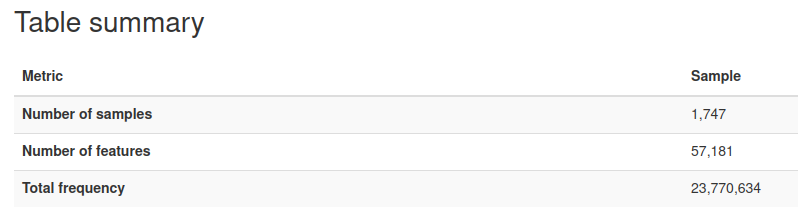

Summary of feature table after pre-processing (ft_summary_cleaned.qzv)
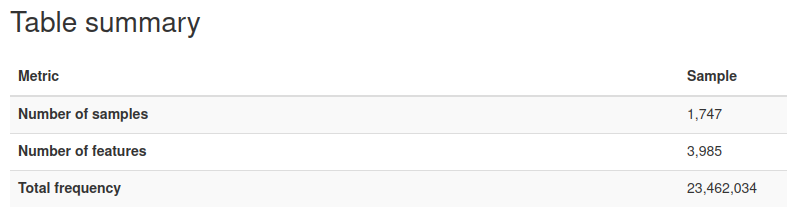

As we can see from the two screenshots of the Table Summary from the two feature tables(ft_summary.qzv and ft_summary_cleaned.qzv) only about 300k total frequency was lost from the preprocessing step, we still retain most of the information we need.

# Feature Table Metrics Analysis

First figure out the feature table rarefication, save the plots generated by Qiime2 core_metrics_phylogenetic, then create the following:
1. Distance matrices: Unifrac distance matricse (Unweighted and Weighted), Jaccard distance matrix, Bray Curtis distance matrix

2. PCOA plots with the different distance matrices
    - save the plots for visualization
    
    
3. UMAP plots with the different distance matrices
    - save the plots for visualization
    
    
4. Finally follow up with a statistical test or regression
    - Ex) PERMANOVA test on PCOA results
    - Ex) Use the reduced dimension embeddings to feed into the regression model

In [ ]:
# Create the feature table metrics object with phylogenetic tree
feat_table = cleaned_feature_table
depth = 7930
metadata = qiime_metadata
feature_table_metrics_phy = core_metrics_phylogenetic(feat_table, tree, depth, metadata)

With the information we gained from the summary, we decided to rarefy the table with a sampling depth of _7930_ we retained _12,489,750 (52.48%) features in 1575 (90.00%) samples_ at the specifed sampling depth. We made this decision to maximize the amount of features while preserving the amount of samples in our data.

In [ ]:
#Save the outputs of the analysis .QZV files into 'outputs' folder to view on view.qiime2.org
dimensionality_analysis.save_pcoa_outputs(feature_table_metrics_phy)

### UMAP Dimensionality Reduction
First i'm going to try to use supervised UMAP with 'disease_type' as the target on samples that only have 1 disease. 
Going to attempt to visualize in the 2D space, 2D plots code will be taken from UMAP documentation.

In [ ]:
feature_df_target_disease, target_disease_map, target_disease_dict = dimensionality_analysis.process_table_umap(table, metadata_df)

In [ ]:
feature_df_target_disease

In [ ]:
embedding = dimensionality_analysis.umap_plot_supervised(feature_df_target_disease, target_disease_map, target_disease_dict,75, 2, "jaccard")

In [ ]:
#UMAP 2D Embeddings of our feature table
embedding

#### Supervised UMAP Plot
The Plot shows clear clustering of the disease types using n_neighbors: 75 and the Jaccard Metric. However we see there are 2 major flaws to this result: the sample size is very small, and a very imbalanced class size among the disease types make this result hard to utilize for further analysis/modeling.

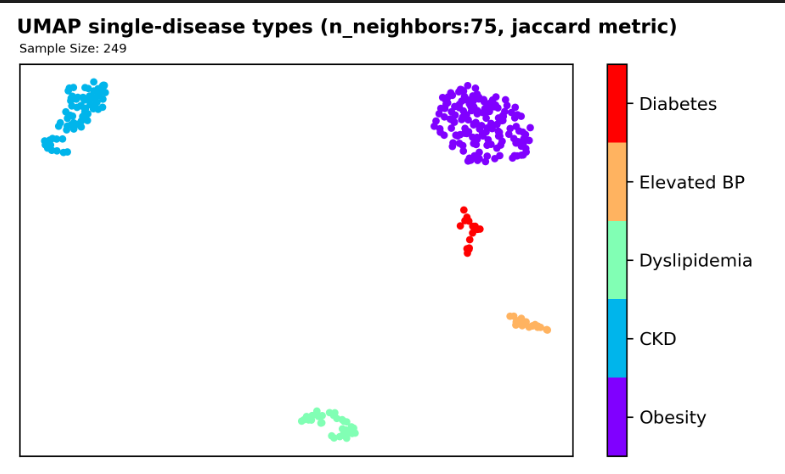

If we could have more samples, specifically data for the underrepresented (more unique) diseases, we could perform further analysis and modeling of the UMAP embeddings, such as using the embeddings as features for a multi-label classification model.